# Kritias

## 1. Finding the point where ChatGPT took over

### 1.1 Text Preprocessing

In [5]:
# imports
import re  # regular expressions
import nltk  # for stemming
import numpy as np  # for matrices
import matplotlib.pyplot as plt  # for graphs

In [6]:
# load files
f_kritias = open('Kritias.txt', 'r')
#f_timaeus = open('Timaeus.txt', 'r')
f_stop_words = open('smart.txt', 'r')  # from exercise sheet 09

In [7]:
# methods to process words from abstract analogous to exercise sheet 09

def tidy_and_stem(words):
    # remove '\'
    words = [word.replace('\'', '') for word in words]
    # remove non-alphabetic characters
    words = [word for word in words if word.isalpha()]
    # stem
    ps = nltk.stem.PorterStemmer()
    return [ps.stem(word) for word in words]

def get_preprocessed_words(abstract, stop_words):
    # remove special characters
    abstract = re.sub(r'\s+|[.,;!?()\"-]+', ' ', abstract)
    words = abstract.split()
    words = tidy_and_stem(words)
    # remove stop words
    words = [word for word in words if word not in stop_words]
    # remove empty strings if there are any
    words = [word for word in words if word]
    return words

In [8]:
stop_words = tidy_and_stem(f_stop_words.read().lower().split())

In [9]:
kriti_sntncs = f_kritias.read().lower().split('.')

### 1.2 Term-Sentence Matrix

In [10]:
# find unique terms
# also save cleaned sentences
unique_terms_set = set()
cleaned_sntncs = []
for sentence in kriti_sntncs:
    clean_sntnc = ""
    for term in get_preprocessed_words(sentence, stop_words):
        unique_terms_set.add(term)
        clean_sntnc = clean_sntnc + " " + term
    cleaned_sntncs.append(clean_sntnc)
unique_terms = list(unique_terms_set)
len(cleaned_sntncs)

192

In [11]:
unique_terms[0:10]

['woven',
 'prove',
 'head',
 'divis',
 'limb',
 'shown',
 'familiar',
 'side',
 'solid',
 'figur']

In [12]:
'atlantis' in unique_terms

False

In [13]:
'atlanti' in unique_terms

True

In [14]:
'atlant' in unique_terms

True

In [15]:
'atlan' in unique_terms

False

In [16]:
'atla' in unique_terms

True

In [17]:
cleaned_sntncs[0:3]

[' socrat arriv weari travel long journey rest pray reveal grant word endur spoken accept unintent wrong pray impos retribut retribut err set',
 ' speak futur gener god pray knowledg medicin perfect',
 ' offer prayer deliv argument critia speak agreement']

In [18]:
# create term-sentence matrix (which is a term-document matrix where the documents are sentences)
term_sntnc_matrix = [
    [
        sum(1 for word in re.findall(r'\b\w+\b', sntnc) if term in sntnc) for sntnc in cleaned_sntncs
    ]
    for term in unique_terms
]

In [19]:
A = np.asmatrix(term_sntnc_matrix)
A

matrix([[ 0,  0,  0, ..., 14,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]])

In [20]:
np.sum(A)

59348

### 1.3 Try to find term discrepancy in halves

In [21]:
# we don't know where ChatGPT took over, but we know that the first half
# of the text has a bigger percentage of original words than the second
half = len(cleaned_sntncs)//2
first_half = cleaned_sntncs[:half]
second_half = cleaned_sntncs[half:]
# count terms

def cnt_term(sentences, term):
    return sum(1 for sntnc in sentences if term in re.findall(r'\b\w+\b', sntnc))
    
def cnt_all_terms(sentences):
    return [cnt_term(sentences, term) for term in unique_terms]
    
term_cnt_first = cnt_all_terms(first_half)
term_cnt_second = cnt_all_terms(second_half)
# find words that appeared at least twice as often in the second half and at least 5 times
second_half_terms = [
    term for term, count_first, count_second in zip(unique_terms, term_cnt_first, term_cnt_second)
    if count_second >= 2 * count_first and (count_first + count_second) >= 5
]
second_half_terms

['divin',
 'width',
 'atlanti',
 'hundr',
 'roof',
 'theme',
 'round',
 'bring',
 'size',
 'poseidon',
 'ten',
 'timaeu',
 'gold',
 'pass',
 'memori',
 'hermocr',
 'law',
 'length',
 'person',
 'wisdom',
 'templ',
 'continu',
 'descend',
 'build',
 'natur',
 'stadium',
 'offer']

In [22]:
# find words that appeared at least twice as often in the first half and at least 5 times
first_half_terms = [
    term for term, count_first, count_second in zip(unique_terms, term_cnt_first, term_cnt_second)
    if 2 * count_second <= count_first and (count_first + count_second) >= 5
]
first_half_terms

['side',
 'sea',
 'made',
 'citizen',
 'requir',
 'sort',
 'anim',
 'abund',
 'largest',
 'world',
 'exist',
 'begin',
 'left',
 'countri',
 'day',
 'children',
 'receiv',
 'cover',
 'acropoli',
 'thing',
 'call',
 'set',
 'men',
 'wood',
 'make',
 'long',
 'water',
 'speak',
 'man',
 'extend',
 'ancient',
 'common',
 'river',
 'twin',
 'island',
 'pair',
 'hill',
 'suitabl',
 'soil',
 'dwelt',
 'earth',
 'time',
 'land',
 'indulg']

In [23]:
# now split kriteas (cleaned_sntncs) in two parts at every point and try to
# maximize the discrepancy of the "significant terms"
discrepency_at_i = []
for i in range(len(cleaned_sntncs)):
    first_part = cleaned_sntncs[:i]
    second_part = cleaned_sntncs[i:]
    discrepency = 0
    for term in second_half_terms:
        first_cnt = cnt_term(first_part, term)
        second_cnt = cnt_term(second_part, term)
        # ideally second_cnt is larger here
        discrepency += (second_cnt - first_cnt)
    for term in first_half_terms:
        first_cnt = cnt_term(first_part, term)
        second_cnt = cnt_term(second_part, term)
        # ideally first_cnt is larger here
        discrepency += (first_cnt - second_cnt)
    discrepency_at_i.append(discrepency)
discrepency_at_i

[-162,
 -158,
 -156,
 -156,
 -156,
 -154,
 -148,
 -146,
 -146,
 -132,
 -132,
 -132,
 -126,
 -122,
 -122,
 -122,
 -114,
 -114,
 -112,
 -112,
 -110,
 -106,
 -108,
 -106,
 -104,
 -100,
 -98,
 -94,
 -94,
 -90,
 -90,
 -88,
 -86,
 -80,
 -74,
 -68,
 -66,
 -64,
 -52,
 -44,
 -32,
 -32,
 -20,
 -14,
 2,
 14,
 20,
 30,
 44,
 50,
 66,
 76,
 78,
 80,
 84,
 98,
 104,
 106,
 116,
 130,
 134,
 140,
 146,
 146,
 148,
 148,
 148,
 148,
 150,
 152,
 154,
 158,
 162,
 172,
 184,
 192,
 202,
 206,
 216,
 222,
 226,
 232,
 234,
 238,
 240,
 248,
 252,
 258,
 268,
 286,
 286,
 294,
 292,
 294,
 300,
 306,
 308,
 306,
 310,
 310,
 306,
 306,
 298,
 288,
 286,
 280,
 274,
 270,
 258,
 254,
 256,
 254,
 254,
 254,
 256,
 256,
 258,
 264,
 266,
 272,
 274,
 286,
 286,
 286,
 282,
 282,
 272,
 274,
 274,
 278,
 276,
 278,
 284,
 284,
 284,
 282,
 278,
 276,
 270,
 268,
 266,
 262,
 256,
 252,
 250,
 246,
 244,
 240,
 242,
 242,
 242,
 242,
 238,
 238,
 238,
 236,
 234,
 230,
 232,
 224,
 222,
 222,
 222,
 220,
 21

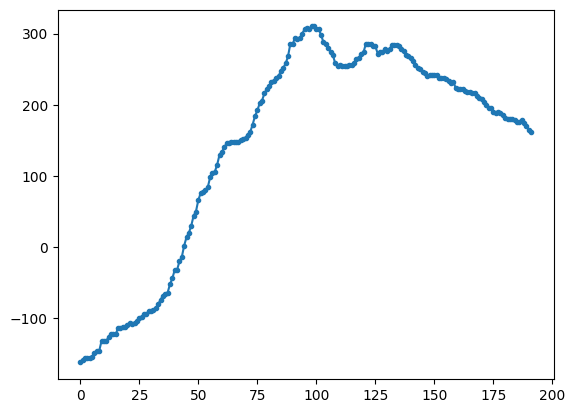

In [24]:
# plot
x = list(range(len(discrepency_at_i)))
plt.plot(x, discrepency_at_i, marker='.')

In [25]:
# find index of maximum value
# Hypothesis: this is the point where ChatGPT took over
discrepency_at_i.index(max(discrepency_at_i))

98

#### 1.4 SVD

In [26]:
# compute AtA
At = A.T
AtA = At @ A  # matrix-multiplication of numpy
AtA

matrix([[11132,   176,   154, ...,   308,   220,     0],
        [  176,   576,   112, ...,     0,    80,     0],
        [  154,   112,   539, ...,    98,    70,     0],
        ...,
        [  308,     0,    98, ...,  3136,     0,     0],
        [  220,    80,    70, ...,     0,  1700,     0],
        [    0,     0,     0, ...,     0,     0,     0]])

In [27]:
# get eigenvalues sorted ascendingly
eigenvalues = np.linalg.eigvals(AtA)
# turn into singular values
singular_values = np.sqrt(eigenvalues)
# construct S (or Sigma)
S = np.diag(singular_values)
singular_values[0:10]

array([438.30201706, 367.41692441, 333.15787153, 282.80281341,
       278.24821959, 246.50765509, 240.71871902, 210.38077331,
       203.65403162, 197.87782173])

In [28]:
# get eigenvectors (sorted by eigenvalues)
eigenvectors = np.linalg.eig(AtA).eigenvectors
# construct Vt
V = eigenvectors
Vt = V.T
Vt

matrix([[ 3.53982743e-02,  3.15746612e-03,  5.90780376e-03, ...,
          3.01636624e-03,  1.12046470e-02,  0.00000000e+00],
        [ 2.22316260e-02,  3.36466996e-03,  4.36995833e-03, ...,
          2.67140836e-03,  8.13027345e-03,  0.00000000e+00],
        [-4.46166505e-02, -8.49435161e-03, -8.04709287e-03, ...,
         -5.05256867e-03,  3.72055665e-03,  0.00000000e+00],
        ...,
        [-4.69540270e-06,  2.72914523e-04,  1.73821359e-04, ...,
          1.17679207e-04,  5.53403708e-04,  0.00000000e+00],
        [ 4.38932057e-17,  4.43793062e-17,  9.74406733e-16, ...,
         -5.44081058e-16, -8.32956418e-17,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [29]:
# compute U
U = A @ V @ np.linalg.pinv(S)
U

matrix([[ 9.63470978e-05,  1.01790948e-04, -2.12319646e-04, ...,
          1.88483490e-03, -4.61249744e-08,  0.00000000e+00],
        [ 8.53371263e-03, -9.27762047e-04, -3.73609637e-03, ...,
         -1.17851963e-02,  4.27820964e-10,  0.00000000e+00],
        [ 1.13186563e-03,  1.70134808e-03, -5.98427935e-04, ...,
          9.36619743e-04,  7.49120524e-10,  0.00000000e+00],
        ...,
        [ 3.62634879e-04,  2.54021100e-04, -3.04427692e-05, ...,
         -6.53692896e-03, -5.68951339e-09,  0.00000000e+00],
        [ 1.50481261e-03,  6.30116549e-04, -2.33105314e-04, ...,
         -3.30406412e-03, -1.10514957e-09,  0.00000000e+00],
        [ 1.84025108e-05,  3.91917399e-05, -9.20337586e-06, ...,
         -7.12442236e-03,  1.66458363e-09,  0.00000000e+00]])

In [30]:
# compare results to numpy.linalg.svd()
npU, npS, npVt = np.linalg.svd(A)
for i in range(len(npS)):
    print("npS: " + str(npS[i]) + ", sv: " + str(singular_values[i]))
# they differ in some places

npS: 438.30201705611495, sv: 438.3020170561152
npS: 367.41692441298767, sv: 367.4169244129882
npS: 333.157871530237, sv: 333.15787153023695
npS: 282.8028134105261, sv: 282.8028134105259
npS: 278.2482195872616, sv: 278.24821958726153
npS: 246.50765509251065, sv: 246.5076550925103
npS: 240.7187190237314, sv: 240.71871902373186
npS: 210.38077331309273, sv: 210.38077331309321
npS: 203.65403162010378, sv: 203.6540316201036
npS: 197.87782173400043, sv: 197.87782173400075
npS: 181.27144806930048, sv: 181.27144806930067
npS: 176.94430584935023, sv: 176.9443058493504
npS: 171.15487518146568, sv: 171.1548751814651
npS: 164.3365179505011, sv: 164.33651795050105
npS: 163.37731451327255, sv: 163.37731451327247
npS: 154.63613161575694, sv: 154.63613161575688
npS: 151.0954562081385, sv: 151.0954562081387
npS: 148.68017759587724, sv: 148.68017759587767
npS: 141.44488737100565, sv: 141.4448873710058
npS: 137.86719025072233, sv: 137.86719025072222
npS: 136.72471511522937, sv: 135.72439312647856
npS: 135

In [31]:
npVt

matrix([[-3.53982743e-02, -3.15746612e-03, -5.90780376e-03, ...,
         -3.01636624e-03, -1.12046470e-02,  0.00000000e+00],
        [-2.22316260e-02, -3.36466996e-03, -4.36995833e-03, ...,
         -2.67140836e-03, -8.13027345e-03,  0.00000000e+00],
        [-4.46166505e-02, -8.49435161e-03, -8.04709287e-03, ...,
         -5.05256867e-03,  3.72055665e-03,  0.00000000e+00],
        ...,
        [ 2.94515559e-04, -1.46690320e-03,  7.21476416e-03, ...,
         -1.99512105e-03, -1.25307429e-04,  0.00000000e+00],
        [ 0.00000000e+00,  3.16076738e-17, -5.71375463e-18, ...,
          3.78762820e-17,  1.40796572e-16,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [32]:
npU

matrix([[-9.63470978e-05, -1.01790948e-04, -2.12319646e-04, ...,
          1.45684521e-03, -4.97536028e-03, -2.37128175e-03],
        [-8.53371263e-03,  9.27762047e-04, -3.73609637e-03, ...,
          1.09230934e-02,  7.21239796e-03,  2.92902186e-03],
        [-1.13186563e-03, -1.70134808e-03, -5.98427935e-04, ...,
          3.74383747e-03, -1.32696269e-02,  4.62551168e-04],
        ...,
        [-3.62634879e-04, -2.54021100e-04, -3.04427692e-05, ...,
          8.97424105e-01,  5.25907589e-03,  2.51963353e-03],
        [-1.50481261e-03, -6.30116549e-04, -2.33105314e-04, ...,
          4.75124697e-03,  9.27060714e-01,  3.16525044e-03],
        [-1.84025108e-05, -3.91917399e-05, -9.20337586e-06, ...,
          1.21558851e-03,  3.00745739e-03,  7.51656442e-01]])

### 1.5 Reducing the Dimension

In [33]:
U, Sigma, Vt = np.linalg.svd(A, full_matrices=False)

In [34]:
k = 10  # Number of dimensions to keep
U_k = U[:, :k]
Sigma_k = np.diag(Sigma[:k])
Vt_k = Vt[:k, :]

In [35]:
# re-create the appoximated term-sentence-matrix
A_k = U_k @ Sigma_k @ Vt_k
A_k

matrix([[ 3.96273663e-03,  3.04930911e-04,  3.49964097e-04, ...,
          1.03588673e-02,  1.20160560e-03,  0.00000000e+00],
        [-6.30081626e-01, -6.50290898e-02, -5.51937279e-02, ...,
          1.33948924e-01,  1.13496215e-01,  0.00000000e+00],
        [ 8.82428624e-02,  1.08834928e-02,  1.39079734e-02, ...,
          3.82101251e-03,  1.36713571e-02,  0.00000000e+00],
        ...,
        [ 1.09649589e-02,  9.33368777e-04,  1.06722780e-03, ...,
          3.15775957e-03,  1.05145278e-03,  0.00000000e+00],
        [ 2.35660889e-02, -2.37628613e-03, -6.36081068e-03, ...,
          1.79387193e-02,  3.57290830e-02,  0.00000000e+00],
        [ 2.11980218e-03,  3.15592692e-04,  3.85038136e-04, ...,
          8.67759774e-06,  4.44136145e-04,  0.00000000e+00]])

The rows of $A \in \mathbb{R}^{m \times n}$ represent the $m$ terms. \
The columns of $A$ represent the $n$ sentences. \
$U_k \in \mathbb{R}^{m \times k}$ maps the rows of $A_k$ (terms). \
$\Sigma_k \in \mathbb{R}^{k \times k}$ scales the values. \
$V^t \in \mathbb{R}^{k \times n}$ maps the columns of $A_k$ (sentences).

In [36]:
# calculating the similarity using cos()
def similarity(u, v):
    return np.dot(u, v) / (linalg.norm(u) * linalg.norm(v))
similarity_0_1 = similarity(U_k[0], U_k[1])

ValueError: shapes (1,10) and (1,10) not aligned: 10 (dim 1) != 1 (dim 0)